# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
import numpy as np
import csv
import tensorflow as tf



# TODO: Fill this in based on where you saved the training and testing data

training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']


# Read the contents of the Sign Names CSV to a dict
sign_dict={}
with open('signnames.csv', mode='r') as infile:
    reader = csv.reader(infile)
    sign_dict = {rows[0]:rows[1] for rows in reader}
del sign_dict['ClassId']


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train.shape[1:3]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)



Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

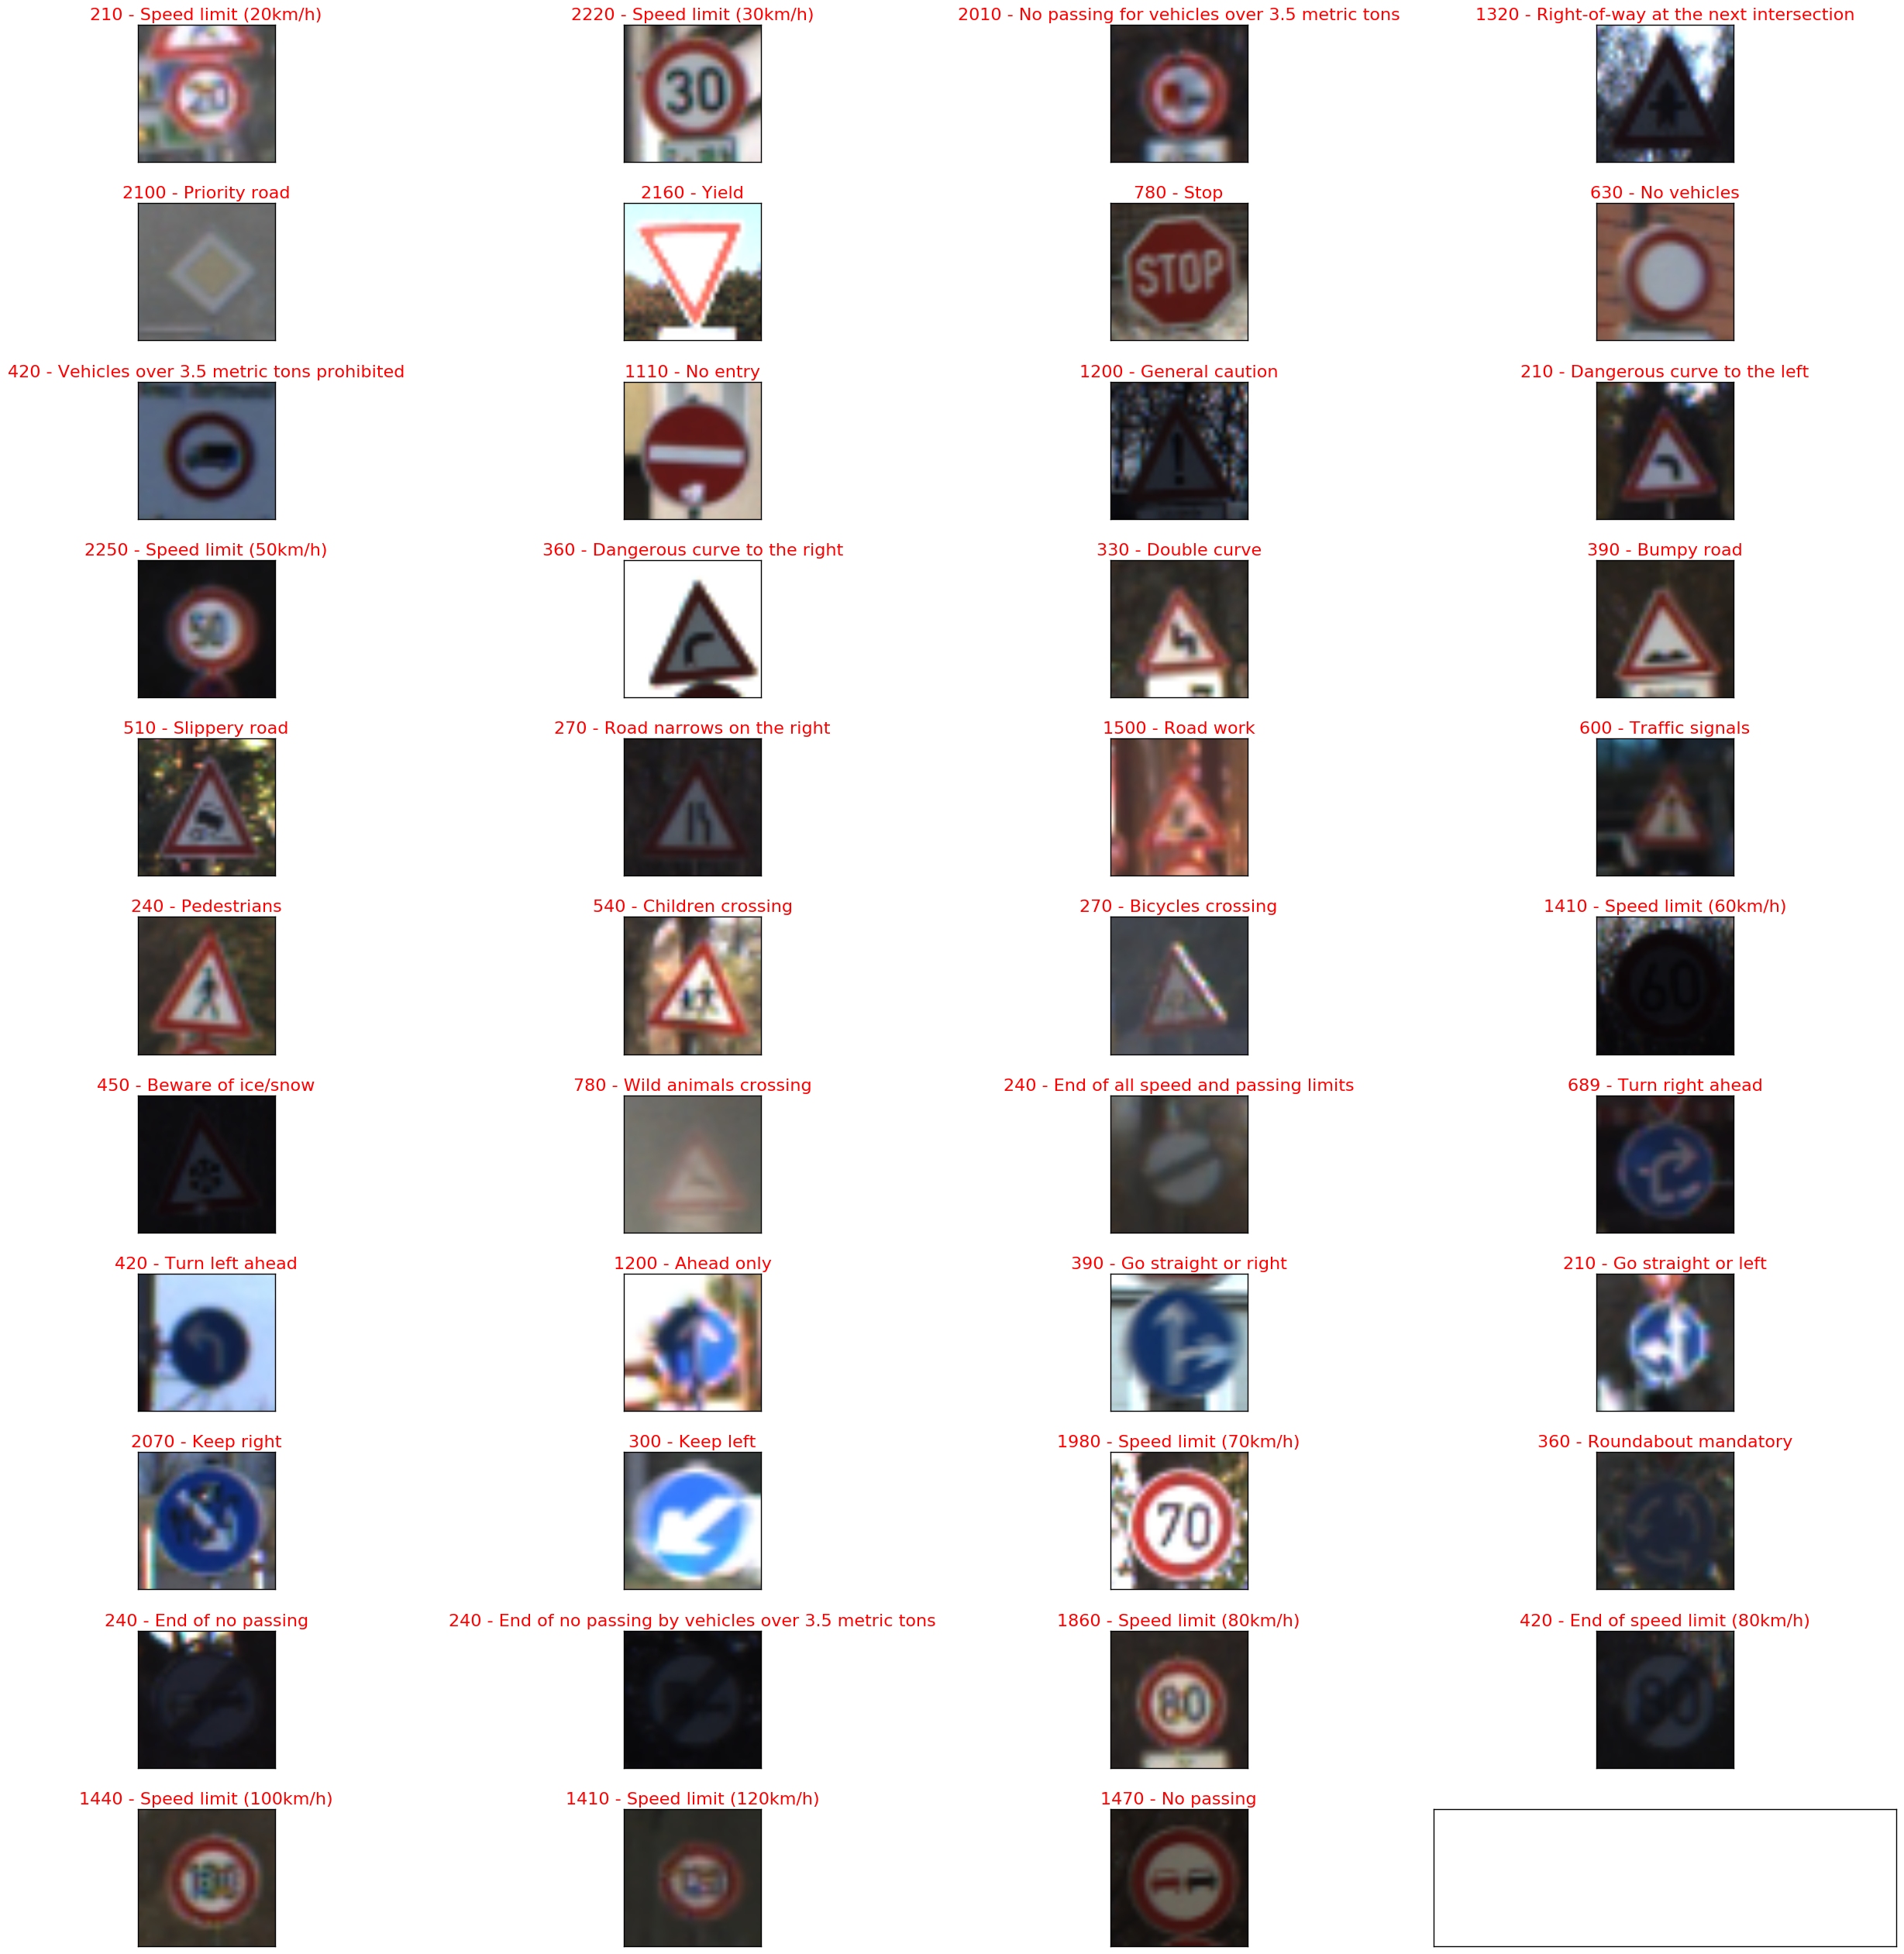

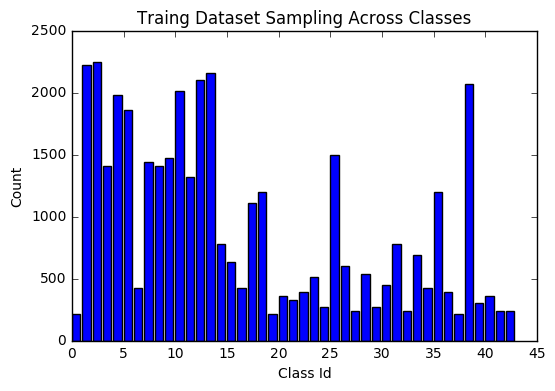

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import random
# Visualizations will be shown in the notebook.
%matplotlib inline
keys = sign_dict.keys()
keys=sorted(keys)


fig, axes = plt.subplots(11, 4, figsize=(32, 32), subplot_kw={'xticks': [], 'yticks': []})
fig.subplots_adjust(hspace=0.3, wspace=0.05)

hist_x=[]
hist_y=[]
for ax,class_id in zip(axes.flat, keys):
    #print(class_id)
    index_list=np.where(y_train==int(class_id))
    feature_loc = np.asarray(index_list).flatten()
    feature_index= random.choice(feature_loc)
    sample_count=len(feature_loc)
    img = X_train[int(feature_index)]
    ax.imshow(img) 
    title=str(sample_count)+ " - "+ sign_dict[class_id] 
    ax.set_title(title , fontsize=16,color='red')
    hist_x.append(class_id)
    hist_y.append(sample_count)
plt.show()


plt.bar(np.asarray(hist_x), hist_y)
plt.title('Traing Dataset Sampling Across Classes')
plt.xlabel('Class Id')
plt.ylabel('Count')
plt.show()




----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [4]:
def balance_training_dataset():
    X_balanced=[]
    y_balanced=[]
    max_class=2250    
    # Progress bar
    pbar = tqdm(range(43), desc='synthesizing data for classes',unit='batches')
    array_index=0;
    progress=0;
    for class_id in range(43):
        index_list=np.where(y_train==int(class_id))
        index_array = np.asarray(index_list).flatten()
        
        for i in range(len(index_array),max_class):
            rand_index= random.choice(index_array)
            rand_angle=random.choice([-3,-2,-1,0,1,3])
            img_rotated=ndimage.rotate(X_train[rand_index],rand_angle,reshape=False)
            X_balanced.append(np.asarray(img_rotated))
            y_balanced.append(int(class_id))
        pbar.update(0.5)  
        
        for k in range(len(index_array)):            
            img=X_train[int(index_array[k])]
            X_balanced.append(img)
            y_balanced.append(int(class_id))        
        pbar.update(0.5)    
    pbar.close()
    
    X_train_balanced=np.squeeze(np.asarray(X_balanced))
    y_train_balanced=np.squeeze(np.asarray(y_balanced))

    print("x_train_balanced:", X_train_balanced.shape, type(X_train_balanced))   
    print("y_train_balanced:", y_train_balanced.shape, type(y_train_balanced))
    return X_train_balanced,y_train_balanced

In [5]:
def normalize_image(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [-0.5, 0.5]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    # 
    image_data= (image_data-128.0)/256.0
    return image_data

In [6]:
### Preprocess the data here.
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
from scipy import ndimage
from tqdm import tqdm
import cv2

# Step 1: Shuffle the training dataset
X_train, y_train = shuffle(X_train, y_train)

# Step 2: Normalize image pixel value 

X_test=normalize_image(X_test)

X_train=normalize_image(X_train)




### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**
The Pre-Processing of the training dataset was done in the following steps:

1. Shuffling the dataset. This would reduce possibility of overfitting for a specific class (Shuffling train dataset done in the next cell)

2. Normalize the dataset. The input dataset has a pixel value that range from 0 to 255. Normalization reduces the dataset values to a range of -0.5 to 0.5 such that it has zero mean and similar variance. This will help the gradient decent optimizer minimize the loss function

In [7]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.
#set as side data for cross validationfrom tqdm import tqdm

# Generate additional data to balance under-sampled data. 


X_train_balanced, y_train_balanced= balance_training_dataset()
print("X_Train_Balanced, y_Train_Balanced :", X_train_balanced.shape,y_train_balanced.shape)
X_train_balanced, y_train_balanced = shuffle(X_train_balanced, y_train_balanced)

# Split the test data such that we set aside 80% for training and 20% for cross-validation

X_training,X_validation, y_training, y_validation = train_test_split(X_train_balanced,y_train_balanced,test_size=0.2, random_state=30)

print("Training dataset size X:" , X_training.shape, "y:",y_training.shape)
print('Validation dataset size X:',X_validation.shape,"y:",y_validation.shape)

synthesizing data for classes: 100%|██████████| 43.0/43 [00:48<00:00,  1.13s/batches]


x_train_balanced: (96750, 32, 32, 3) <class 'numpy.ndarray'>
y_train_balanced: (96750,) <class 'numpy.ndarray'>
X_Train_Balanced, y_Train_Balanced : (96750, 32, 32, 3) (96750,)
Training dataset size X: (77400, 32, 32, 3) y: (77400,)
Validation dataset size X: (19350, 32, 32, 3) y: (19350,)


### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**
The Training data was set up in the following steps:

1. Created additional data to correct the im-balanced in the dataset provided. The additional data was generated for the under represented classes by randomly rotating the image by -2 to +2 degrees. The final dataset has equal representation of all the classes.

2. The balanced data was shuffled before spliting in 80:20 ratio for training and cross-validation


In [8]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
from tensorflow.contrib.layers import flatten

def LeNet(x,keep_prob):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)


    fc1 = tf.nn.dropout(fc0,keep_prob)
        
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b

    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)
    
    fc1 = tf.nn.dropout(fc1,keep_prob)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2,keep_prob)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output =43
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84,43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b    
    return logits



### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build 
a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

The architecture used is based on the LeNet model used for MNIST data. Dropout were added between the fully connected layers

The final architecture is as follows:

1. Conv Layer 1:
        Convolution with input shaped of 32x32x3 and ouput of 28x28x6  (Input shape was modified to account for RGB channels)
        Relu Activation
        Max pooling with output of 14x14x6
2. Conv Layer 2:
        Convolution with ouput of 10x10x16
        Relu Activation
        Max pooling with output of 5x5x16    
3. Dropout Layer with keep probability set to 0.5 for training and 1.0 for test
4. Fully Connected Layer 1:
       Input of 400 and output of 120
       Relu Activation
5. Dropout Layer with keep probability set to 0.5 for training and 1.0 for test. 
6. Fully Connected Layer 2:
       Input of 120 and output of 83
       Relu Activation
7. Dropout Layer with keep probability set to 0.5 for training and 1.0 for test.  
8. Fully Connected Layer 3:
       Input of 83 and output of 43



In [9]:
### Train your model here.

rate = 0.001
EPOCHS = 20
BATCH_SIZE = 128


x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43)

logits = LeNet(x,keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
predict=tf.argmax(logits,1)
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y,keep_prob: 1})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_training)    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_training, y_training = shuffle(X_training, y_training)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_training[offset:end], y_training[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
    saver.save(sess,"lenet")
    print("session saved")        
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Training...

EPOCH 1 ...
Validation Accuracy = 0.856

EPOCH 2 ...
Validation Accuracy = 0.933

EPOCH 3 ...
Validation Accuracy = 0.958

EPOCH 4 ...
Validation Accuracy = 0.973

EPOCH 5 ...
Validation Accuracy = 0.975

EPOCH 6 ...
Validation Accuracy = 0.984

EPOCH 7 ...
Validation Accuracy = 0.986

EPOCH 8 ...
Validation Accuracy = 0.989

EPOCH 9 ...
Validation Accuracy = 0.990

EPOCH 10 ...
Validation Accuracy = 0.991

EPOCH 11 ...
Validation Accuracy = 0.992

EPOCH 12 ...
Validation Accuracy = 0.992

EPOCH 13 ...
Validation Accuracy = 0.993

EPOCH 14 ...
Validation Accuracy = 0.994

EPOCH 15 ...
Validation Accuracy = 0.993

EPOCH 16 ...
Validation Accuracy = 0.993

EPOCH 17 ...
Validation Accuracy = 0.994

EPOCH 18 ...
Validation Accuracy = 0.995

EPOCH 19 ...
Validation Accuracy = 0.994

EPOCH 20 ...
Validation Accuracy = 0.995

session saved
Test Accuracy = 0.946


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_

**Answer:**
The model was trained using a learning rate of 0.001, batch size of 128 over 20 Epochs. The initial weights was generated using a guasian distribution of mean 0 and standard deviation of 0.1. The implementation uses the Adams optimizer for the gradient decent optimization. These parameters resulted in a steady convergence to give validation accuracy of 99% and test accuracy of 94.6%

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

I started out modifying the LeNet implementation used for MNINST data. Generated additional data to balance the under-sampled classes. Added dropout layers in the implmentation to increase reliablity and prevent overfitting. The model should slight improvement in the accuracy when additional data was generated to correct for the under-sampling of certain classes. 


---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

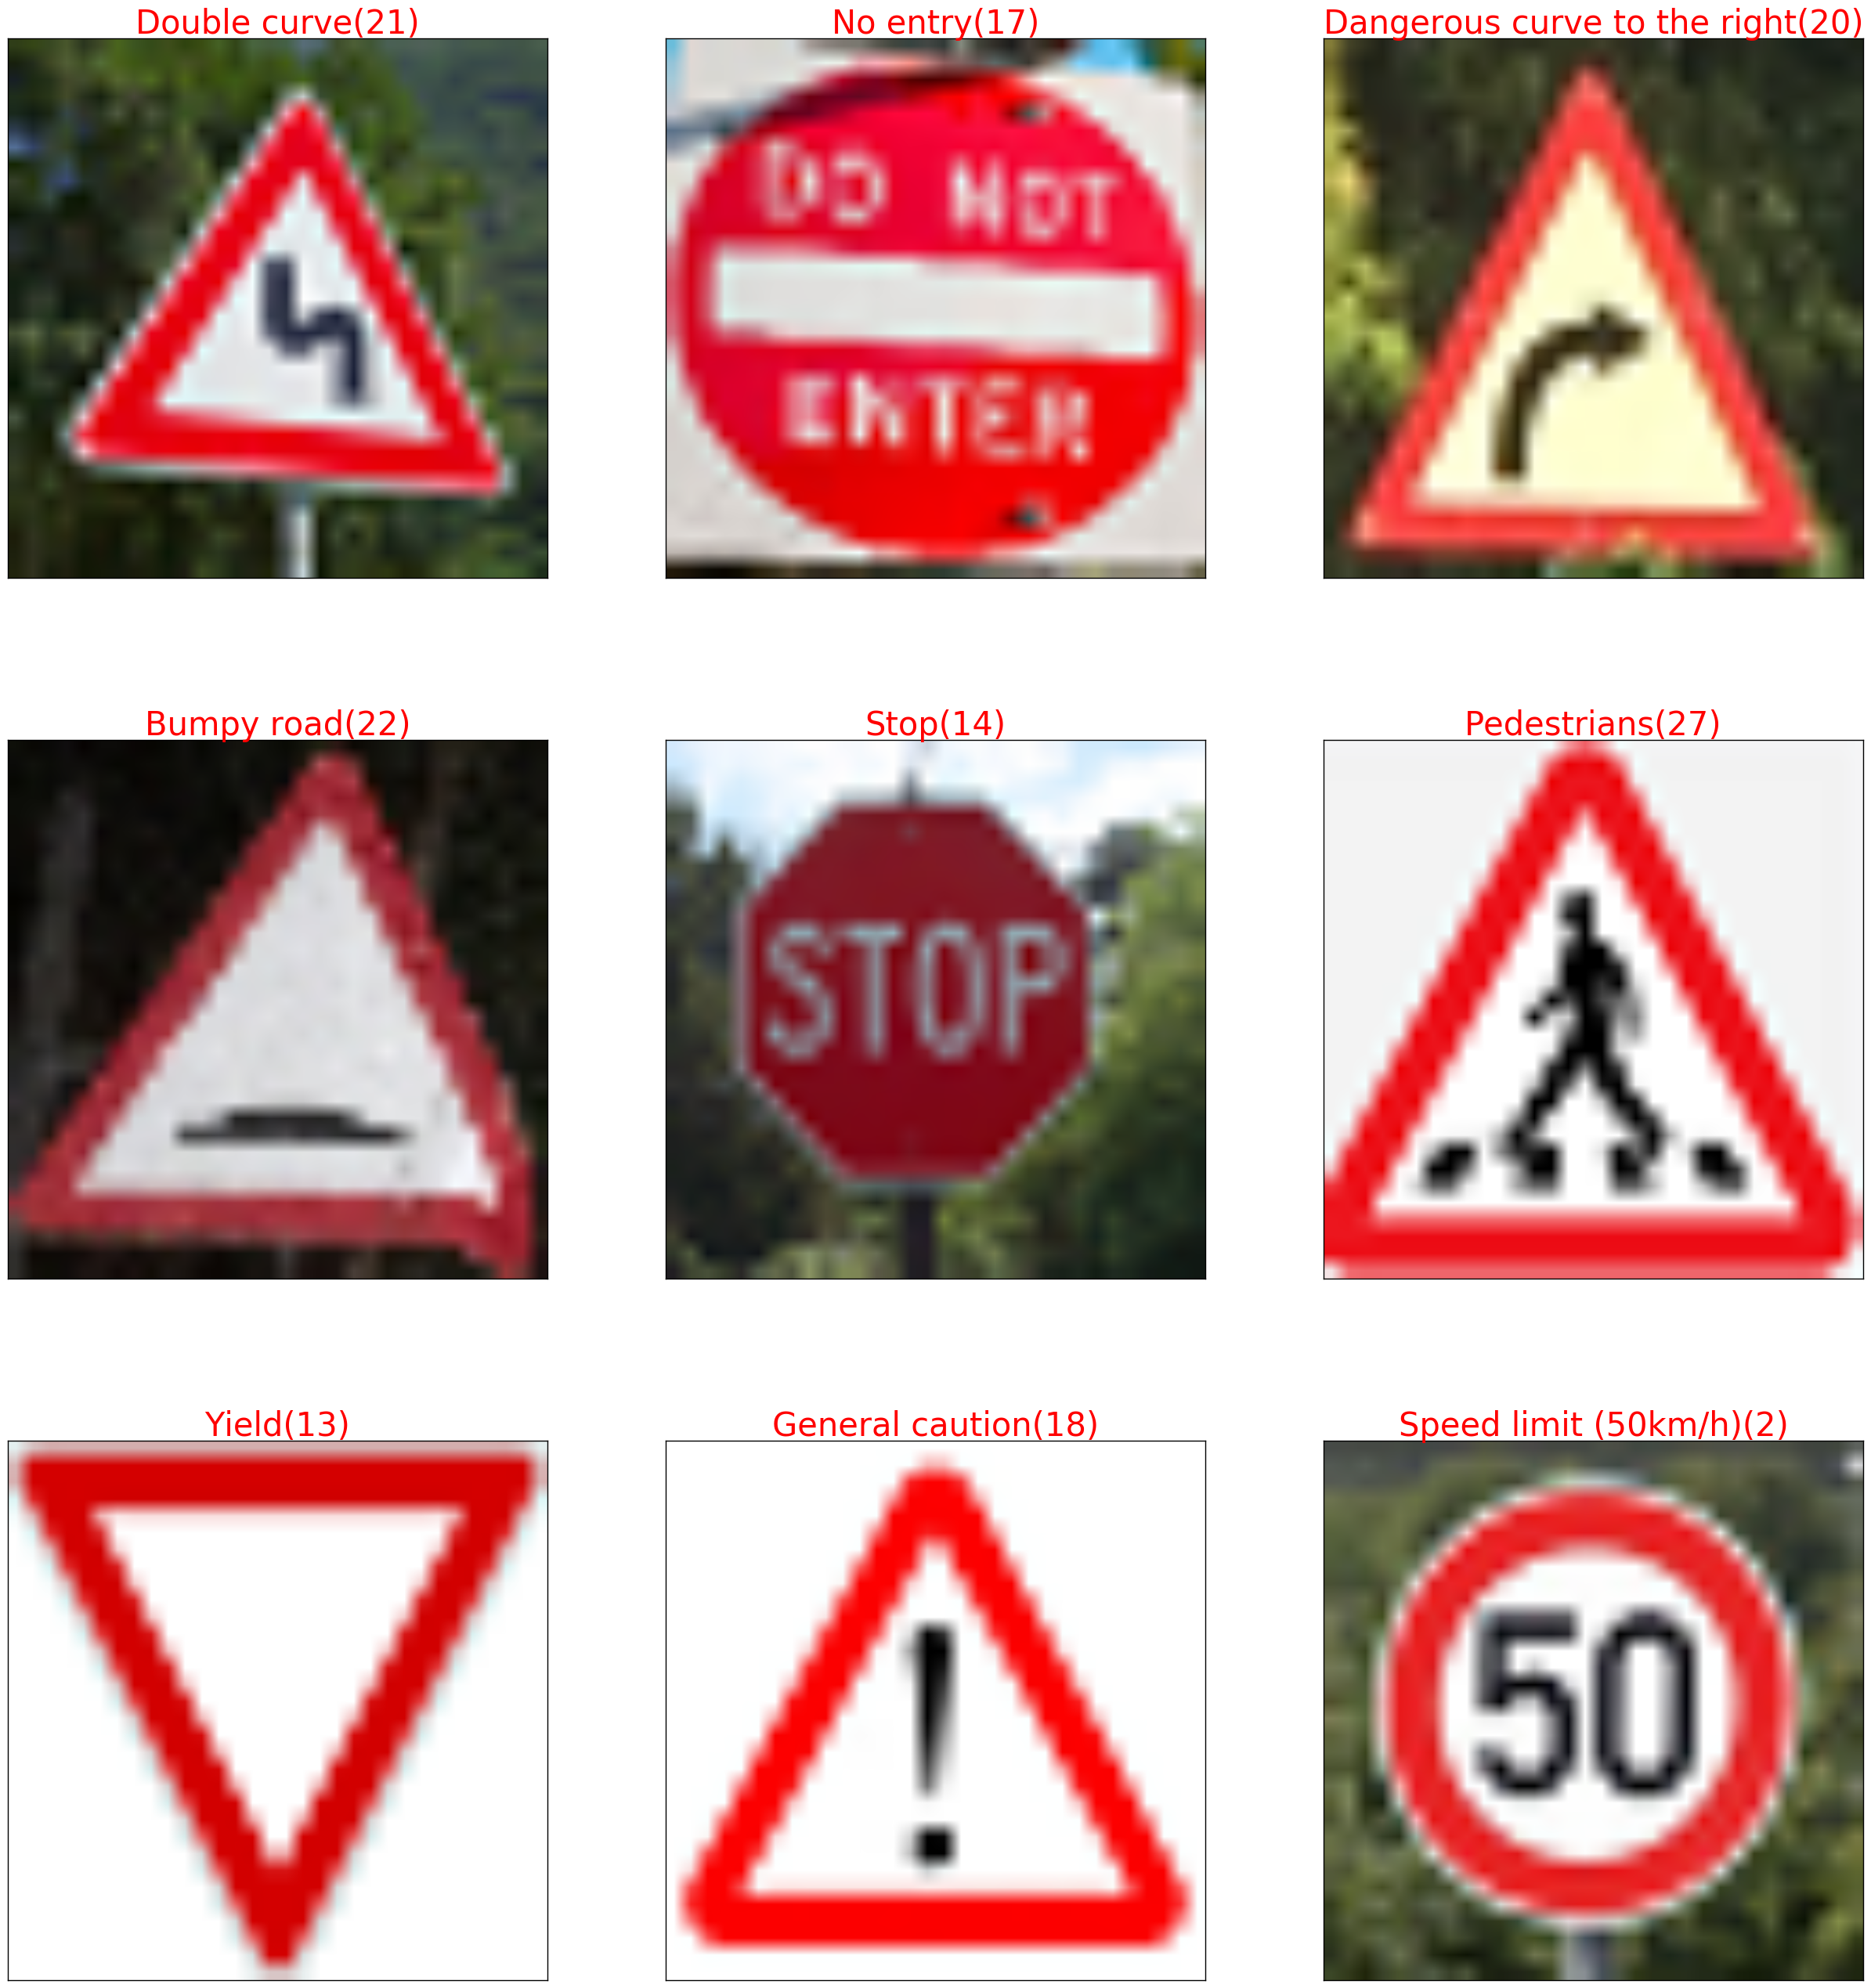

(9, 32, 32, 3) (9,)


In [26]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.




fig, axes = plt.subplots(3, 3, figsize=(32, 32), subplot_kw={'xticks': [], 'yticks': []})
fig.subplots_adjust(hspace=0.3, wspace=0.05)
image_list=[]
expected_class=[21,17,20,22,14,27,13,18,2]
for ax,i in zip(axes.flat, range(0,10)):
    fname="test"+str(i+1)+".png"    
    raw = plt.imread(fname)
    img=raw[:,:,:3]
    ax.imshow(img) 
    title=fname 
    ax.set_title(sign_dict[str(expected_class[i])]+ "("+ str(expected_class[i])+")" , fontsize=30,color='red')
    image_list.append(img)
plt.show()
X_input=np.asarray(image_list,dtype=np.float32) 
y_expected_output=np.asarray(expected_class)
print(X_input.shape,y_expected_output.shape)



In [27]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
normalized_input=X_input-0.50
count=0
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))    
    output= sess.run(predict,feed_dict={x:normalized_input,keep_prob:1})
    
    for i in range(len(output)):
        print("Predicted Class Type:", output[i], " Actual Class Type:", y_expected_output[i]," Desc:",sign_dict[str( y_expected_output[i])])
        if int(output[i])==int(y_expected_output[i]):
            count=count+1
    print("Accuracy on test data=",int(count/len(output)*100),"%")    
    


Predicted Class Type: 31  Actual Class Type: 21  Desc: Double curve
Predicted Class Type: 17  Actual Class Type: 17  Desc: No entry
Predicted Class Type: 20  Actual Class Type: 20  Desc: Dangerous curve to the right
Predicted Class Type: 22  Actual Class Type: 22  Desc: Bumpy road
Predicted Class Type: 14  Actual Class Type: 14  Desc: Stop
Predicted Class Type: 18  Actual Class Type: 27  Desc: Pedestrians
Predicted Class Type: 13  Actual Class Type: 13  Desc: Yield
Predicted Class Type: 18  Actual Class Type: 18  Desc: General caution
Predicted Class Type: 2  Actual Class Type: 2  Desc: Speed limit (50km/h)
Accuracy on test data= 77 %


### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

Test Image 1 - Double Curve: The model failed the predict the image correctly. The model falsely predicted it is wild animal crossing. The sign for animal crossing share similar triangular shape and color schema. The slanted prepective of the input test image could be a reason for the misclassification.

Test Image 2 - No Entry:  The model properly classified the sign.

Test Image 3 - Dangerour Curve to Right: The model properly classified the sign

Test Image 4 - Bumpy road: The model properly classified the sign despite the deformation of the sign.

Test Image 5 - Stop sign: The model properly classified the sign.


* Comment on additional image:
The pedestrian crossing image was miss-classified.  This could be because the pedestrian crossing image provided has addditional features that are not in the training dataset. Specifically the predestrian crossing image has stripped walkway underneath the human figure, which is not there in the training dataset.


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

The model shows an accuracy of 77% in the real world compared to 94.6 % on the test dataset provided. On the outset this could indicate that model did not perform as well as the training/test dataset. However, we have to keep in mind that test the was performed on a small  dataset of only 9 real world images. Some of the reason for the lower performance are:

1. The real world dataset such as the pedestrian crossing has addditional features that are not in the training dataset. Specifically the predestrian crossing image has stripped walkway underneath the human figure, which is not there in the training dataset. 

2. The real world image could have different view prespective.

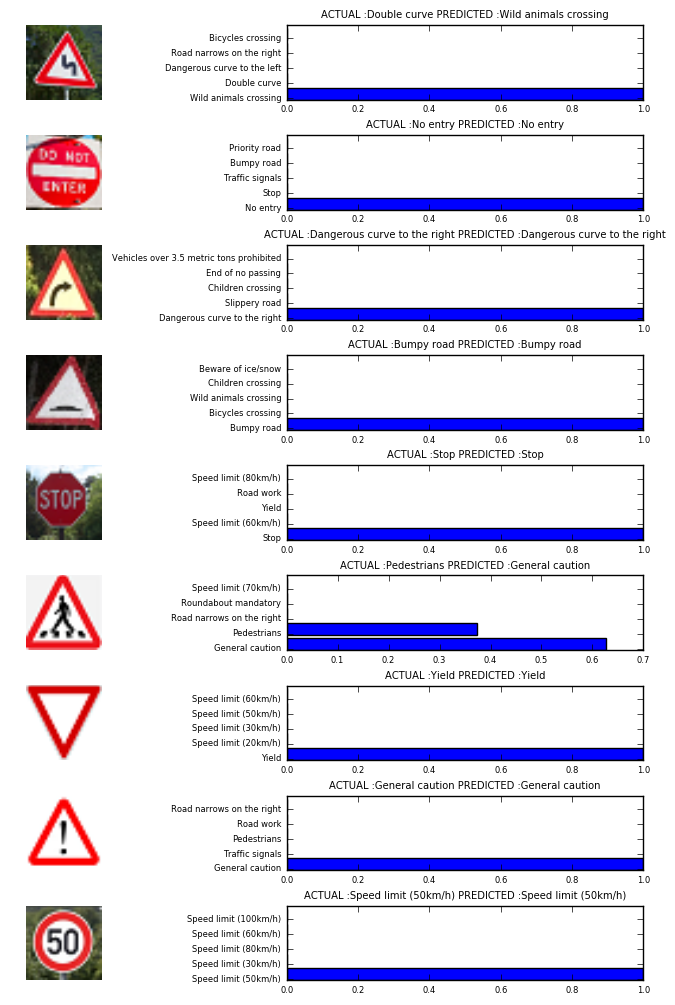

In [31]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
k=5
plt.rcParams['figure.figsize'] = (8.0, 10.0)
plt.rcParams.update({'font.size': 6})
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    output= sess.run(tf.nn.softmax(logits),feed_dict={x:normalized_input,keep_prob:1})   
    for i in range(len(output)):
        smax=output[i]
        top_val,top_ind=sess.run(tf.nn.top_k(smax,k=k))
        labels=[]
        for index in range(len(top_ind)):
            labels.append(sign_dict[str(top_ind[index])])
        #print(labels)  
        #print(top_val*100)
        plt.subplot(len(output), 2, (2*i)+1)
        plt.imshow(X_input[i])
        plt.axis('off')
        plt.subplot(len(output),2,(2*i)+2)
        plt.barh(np.arange(k),top_val)
        plt.yticks(np.arange(k)+0.1,labels)
        disp="ACTUAL :"+sign_dict[str(expected_class[i])]+" PREDICTED :"+ sign_dict[str(np.argmax(smax))]
        #plt.title(sign_dict[str(expected_class[i])])
        plt.title(disp)
        plt.tight_layout()



### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

The model correctly predicted 7 out of the 9 test images.

For the test cases where the models correctly predicted the sign, the model shows high confidence in the prediction. 

For test case where the predictions were wrong, the following is observed:

1. In the case of "Double curve", the model incorrectly predicted it as animal crossing. However, the correct prediction was ranked 2nd in the list. The Tilted prespective of the image could be reason for the misclassification.

2. In the case of "Predestrian" crossing the model incorrectly predicted it as "right of way intersection". However, the correct prediction was ranked 2nd on the list. I would still consider this good prediction given that the test image has different feature to indicate the predestrian compared to the training images. The test image has cross-striped line to indicate the crossing where as the training image only has the human figure.



> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.